In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import os
from itertools import product
from functions import (load_parameters, load_generation_data, load_price_data, generate_randomized_generation,
generate_rt_scenarios, plot_generation_data, plot_randomized_generation, plot_scenarios_for_generator, plot_rt_scenarios)

generation_data, I, T = load_generation_data(date_filter="2022-07-18")
S, R, P_RT, K, K0, M1, M2 = load_parameters(I, T, generation_data)
P_DA, P_PN = load_price_data()

✅ 총 5개 파일을 불러왔습니다: 1201.csv, 137.csv, 401.csv, 524.csv, 89.csv
📊 데이터 Shape: I=5, T=24, S=10
✅ 시뮬레이션 초기화 완료: S=10, Randomness='high', M1=758.40, M2=1855.82


/Users/jangseohyun/Documents/workspace/symply/DER/functions.py:95: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  nyc_rt["Hour"] = nyc_rt["Time Stamp"].dt.floor("H")


In [18]:
agg = gp.Model("agg")
agg.setParam("MIPGap", 1e-7)

a = agg.addVars(T, vtype=GRB.CONTINUOUS, name="alpha")
bp = agg.addVars(T, S, vtype=GRB.CONTINUOUS, name="beta_plus")
bm = agg.addVars(T, S, vtype=GRB.CONTINUOUS, name="beta_minus")
g = agg.addVars(T+1, S, vtype=GRB.CONTINUOUS, name="gamma")
gc = agg.addVars(T, S, vtype=GRB.CONTINUOUS, name="gamma_charge")
gd = agg.addVars(T, S, vtype=GRB.CONTINUOUS, name="gamma_discharge")
eta = agg.addVars(T, S, vtype=GRB.BINARY, name="eta")
lam = agg.addVars(T, S, vtype=GRB.BINARY, name="lambda")
mu = agg.addVars(T, S, vtype=GRB.BINARY, name="mu")

agg.update()

obj = gp.quicksum(P_DA[t] * a[t] for t in range(T)) + \
      gp.quicksum(1 / S * (P_RT[t, s] * bp[t, s] - P_PN[t] * bm[t, s])
                  for t, s in product(range(T), range(S)))

agg.setObjective(obj, GRB.MAXIMIZE)

for t, s in product(range(T), range(S)):
    agg.addConstr(gp.quicksum(R[i, t, s] for i in range(I)) - a[t] == bp[t, s] - bm[t, s] + gc[t, s] - gd[t, s])
    agg.addConstr(gp.quicksum(R[i, t, s] for i in range(I)) + g[t, s] >= bp[t, s])
    agg.addConstr(g[t + 1, s] == g[t, s] + gc[t, s] - gd[t, s])
    agg.addConstr(gd[t, s] <= g[t, s])
    agg.addConstr(gc[t, s] <= sum(K) - g[t, s])
    agg.addConstr(bp[t, s] <= M2 * mu[t, s])
    agg.addConstr(bm[t, s] <= M2 * (1 - mu[t, s]))
    agg.addConstr(bm[t, s] <= M2 * eta[t, s])
    agg.addConstr(gc[t, s] <= M2 * (1 - eta[t, s]))
    agg.addConstr(gc[t, s] <= M2 * lam[t, s])
    agg.addConstr(gd[t, s] <= M2 * (1 - lam[t, s]))
for s in range(S):
    agg.addConstr(g[0, s] == sum(K0))

agg.optimize()

if agg.status == GRB.OPTIMAL:
    print(f"Optimal solution found! Objective value: {agg.objVal}")
else:
    print("No optimal solution found.")

a_vals = np.array([a[t].X for t in range(T)])
bp_vals = np.array([[bp[t, s].X for s in range(S)] for t in range(T)])
bm_vals = np.array([[bm[t, s].X for s in range(S)] for t in range(T)])
g_vals  = np.array([[g[t, s].X  for s in range(S)] for t in range(T)])
gc_vals = np.array([[gc[t, s].X for s in range(S)] for t in range(T)])
gd_vals = np.array([[gd[t, s].X for s in range(S)] for t in range(T)])

Set parameter MIPGap to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.3.0 24D81)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
MIPGap  1e-07

Optimize a model with 2650 rows, 1954 columns and 6490 nonzeros
Model fingerprint: 0xfd921679
Variable types: 1234 continuous, 720 integer (720 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [5e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 2e+03]
Presolve removed 81 rows and 30 columns
Presolve time: 0.01s
Presolved: 2569 rows, 1924 columns, 6507 nonzeros
Variable types: 1204 continuous, 720 integer (720 binary)
Found heuristic solution: objective 1564972.3665

Root relaxation: objective 1.738434e+06, 1163 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    

In [19]:
da_profit = sum(P_DA[t] * a[t].X for t in range(T))
rt_profit = sum(P_RT[t, s] * bp[t, s].X / S for t in range(T) for s in range(S))
pn_cost   = sum(P_PN[t] * bm[t, s].X / S for t in range(T) for s in range(S))
total_profit = da_profit + rt_profit - pn_cost
print("[AGGREGATION MODEL]")
print(f"DA Profit      = {da_profit:.2f}")
print(f"RT Profit      = {rt_profit:.2f}")
print(f"Penalty Cost   = {pn_cost:.2f}")
print(f"Total Profit   = {total_profit:.2f}")

[AGGREGATION MODEL]
DA Profit      = 243133.82
RT Profit      = 1494094.88
Penalty Cost   = 3264.13
Total Profit   = 1733964.58



[AGG MODEL] Day-Ahead Commitment (alpha values):
TOTAL: 1647.24


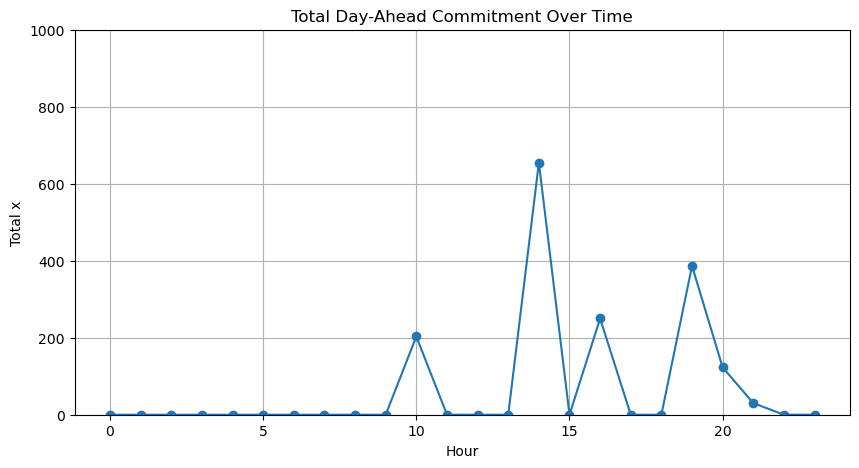

In [20]:
print("\n[AGG MODEL] Day-Ahead Commitment (alpha values):")
total_agg_commit = 0
for t in range(T):
    alpha_t = a[t].X
    total_agg_commit += alpha_t
    # print(f"Time {t}: {alpha_t:.2f}")
print(f"TOTAL: {total_agg_commit:.2f}")

plt.figure(figsize=(10, 5))
plt.plot(range(T), a_vals, marker='o')
plt.title("Total Day-Ahead Commitment Over Time")
plt.xlabel("Hour")
plt.ylabel("Total x")
plt.ylim(0,1000)
plt.grid(True)
plt.show()

In [21]:
for t in range(13,15):
    for s in range(0,3):
        sum_R = R[:, t, s].sum()
        alpha_val = a[t].X
        bp_val = bp[t, s].X
        bm_val = bm[t, s].X
        gc_val = gc[t, s].X
        gd_val = gd[t, s].X

        lhs = sum_R - alpha_val
        rhs = bp_val - bm_val + gc_val - gd_val

        print(f"[t={t:02d}, s={s:02d}]  ∑R={sum_R:.2f}, α={alpha_val:.2f}, β⁺={bp_val:.2f}, β⁻={bm_val:.2f}, γᶜ={gc_val:.2f}, γᴰ={gd_val:.2f}")
        # print(f"              LHS = {lhs:.2f}, RHS = {rhs:.2f}")

[t=13, s=00]  ∑R=1399.43, α=0.00, β⁺=1855.82, β⁻=0.00, γᶜ=0.00, γᴰ=456.39
[t=13, s=01]  ∑R=1717.81, α=0.00, β⁺=1717.81, β⁻=0.00, γᶜ=0.00, γᴰ=0.00
[t=13, s=02]  ∑R=1342.25, α=0.00, β⁺=1778.79, β⁻=0.00, γᶜ=0.00, γᴰ=436.54
[t=14, s=00]  ∑R=1113.95, α=654.57, β⁺=0.00, β⁻=0.00, γᶜ=459.37, γᴰ=0.00
[t=14, s=01]  ∑R=1507.80, α=654.57, β⁺=353.23, β⁻=0.00, γᶜ=500.00, γᴰ=0.00
[t=14, s=02]  ∑R=1091.11, α=654.57, β⁺=0.00, β⁻=0.00, γᶜ=436.54, γᴰ=0.00


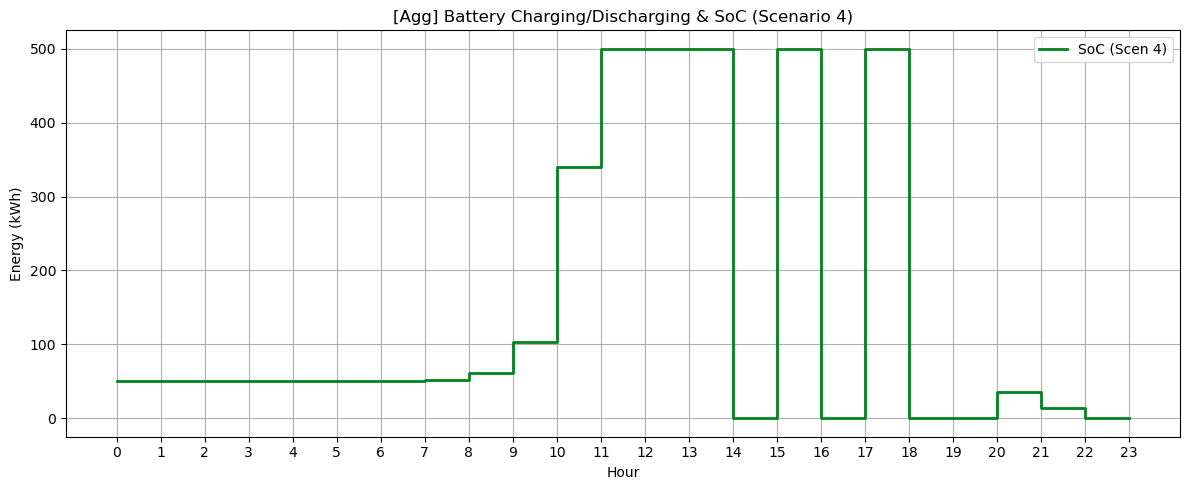

In [22]:
s = 4
gc_single = gc_vals[:, s]  # (T,)
gd_single = gd_vals[:, s]
g_single  = g_vals[:, s]
hours = np.arange(T)

plt.figure(figsize=(12, 5))
# plt.step(hours, gc_single, where='post', label=f"Charge (Scen {s})", marker='^')
# plt.step(hours, gd_single, where='post', label=f"Discharge (Scen {s})", marker='v')
plt.step(hours, g_single, where='post', label=f"SoC (Scen {s})", color='#00821E', linewidth=2)

plt.title(f"[Agg] Battery Charging/Discharging & SoC (Scenario {s})")
plt.xlabel("Hour")
plt.ylabel("Energy (kWh)")
plt.xticks(hours)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()